In [1]:
f(V) = abs(V)*sqrt(log(abs(V)+1)) + 1
function f′(V)
    if V == 0
        return 0
    else
        w = sqrt(log(abs(V)+1))
        V/(2* (abs(V)+1) * w) + (V >= 0 ? w : -w)
    end
end;

In [2]:
using PyPlot

In [3]:
function fnplot(f, xlist)
    plot(xlist, f.(xlist))
end;

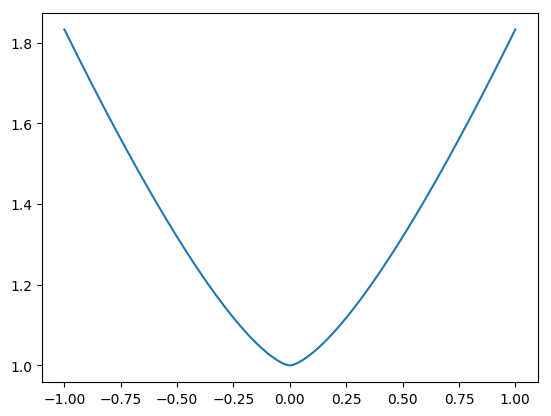

In [4]:
fnplot(f, -1:0.01:1);

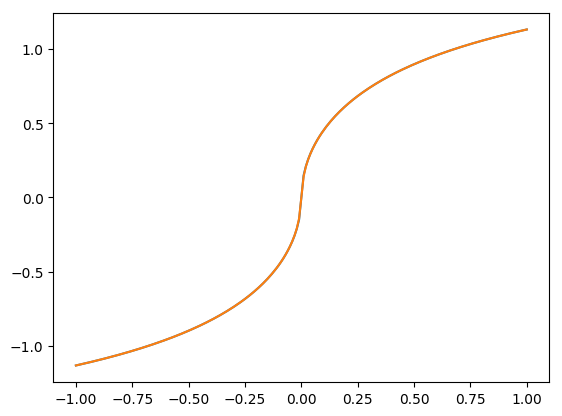

In [5]:
fnplot(f′, -1:0.01:1)
fnplot(x -> (f(x+0.01)-f(x-0.01))/0.02, -1:0.01:1);

In [6]:
per1(V) = 2f(V/2)
@assert per1(5) ≈ 2f(2.5)

In [7]:
per212(V₁, V₂) = per1(V₁) + per1(V₁+V₂)
@assert per212(3,4) ≈ 2f(1.5) + 2f(3.5)

In [8]:
function per12(V₁, V₂)
    Ṽmin = -(V₁ + V₂)/2
    Ṽmax = -V₁
    Ṽ = (Ṽmin + Ṽmax)/2
    Ṽold = nothing
    while Ṽ != Ṽold
        test = f′(Ṽ) + f′(Ṽ+V₁) + f′(Ṽ+V₁+V₂)
        if test < 0
            Ṽmin = Ṽ
        elseif test > 0
            Ṽmax = Ṽ
        else
            break
        end
        Ṽold = Ṽ
        Ṽ = (Ṽmin + Ṽmax)/2
    end
    f(Ṽ) + f(Ṽ+V₁) + f(Ṽ+V₁+V₂)
end;    

In [9]:
@assert per12(6,6) ≈ f(0)+2f(6)
@assert per12(0.01,0.01) ≈ f(0)+2f(0.01)
@assert per12(10000,10000) ≈ f(0)+2f(10000)
@assert per12(3,4) ≈ minimum([f(Ṽ) + f(Ṽ+3) + f(Ṽ+7) for Ṽ in -7.5:0.0001:-3])
@assert per12(0.02,0.08) ≈ minimum([f(Ṽ) + f(Ṽ+0.02) + f(Ṽ+0.1) for Ṽ in -0.05:0.0001:-0.02])
@assert per12(3000,50000) ≈ minimum([f(Ṽ) + f(Ṽ+3000) + f(Ṽ+53000) for Ṽ in -26500:0.01:-3000])
@assert per12(0.6,700) ≈ minimum([f(Ṽ) + f(Ṽ+0.6) + f(Ṽ+700.6) for Ṽ in -350.3:0.001:-0.6])

In [10]:
function makelist(min, max, num)
    h = (max - min)/num
    linspace(min+h/2, max-h/2, num), linspace(min, max, num)
end;

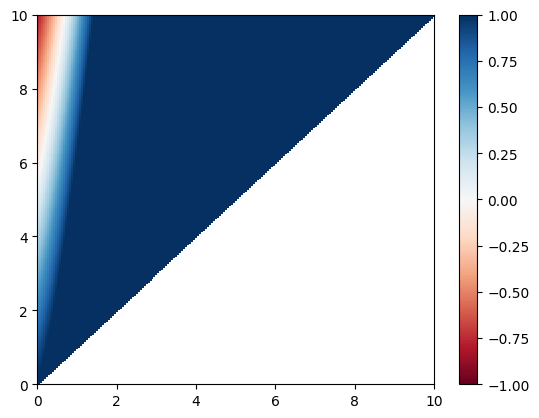

In [11]:
V₁list, V₁axis = makelist(0, 10, 200)
V₂list, V₂axis = makelist(0, 10, 200)

M = [[V₁≤V₂ ? per212(V₁,V₂) - per12(V₁,V₂) : NaN for V₁ in V₁list] for V₂ in V₂list]
pcolormesh(V₁axis, V₂axis, M, cmap="RdBu", vmin=-1, vmax=1)
colorbar();

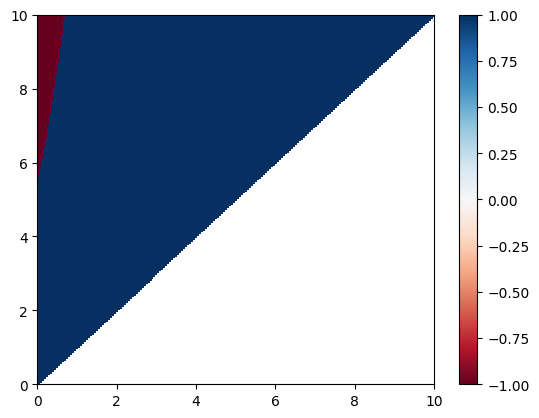

In [12]:
V₁list, V₁axis = makelist(0, 10, 200)
V₂list, V₂axis = makelist(0, 10, 200)

M = [[V₁≤V₂ ? sign(per212(V₁,V₂) - per12(V₁,V₂)) : NaN for V₁ in V₁list] for V₂ in V₂list]
pcolormesh(V₁axis, V₂axis, M, cmap="RdBu", vmin=-1, vmax=1)
colorbar();

In [13]:
per32123(V₁, V₂, V₃) = per1(V₁) + per1(V₁+V₂) + per1(V₁+V₂+V₃);

In [14]:
per3123(V₁, V₂, V₃) = per12(V₁,V₂) + per1(V₁+V₂+V₃);

In [15]:
per2313(V₁, V₂, V₃) = f′(V₃+V₁/2) > f′(V₂+V₁/2) + f′(V₁/2) ? per12(V₂,V₁+V₃) + per1(V₁) : NaN;

In [16]:
function per213(V₁, V₂, V₃)
    Ṽmin = -(V₁ + V₂ + V₃)
    Ṽmax = 0
    Ṽ = (Ṽmin + Ṽmax)/2
    Ṽold = nothing
    while Ṽ != Ṽold
        test = f′(Ṽ) + f′(Ṽ+V₂) + f′(Ṽ+V₂+V₁) + f′(Ṽ+V₂+V₁+V₃)
        if test < 0
            Ṽmin = Ṽ
        elseif test > 0
            Ṽmax = Ṽ
        else
            break
        end
        Ṽold = Ṽ
        Ṽ = (Ṽmin + Ṽmax)/2
    end
    f(Ṽ) + f(Ṽ+V₂) + f(Ṽ+V₂+V₁) + f(Ṽ+V₂+V₁+V₃)
end;  

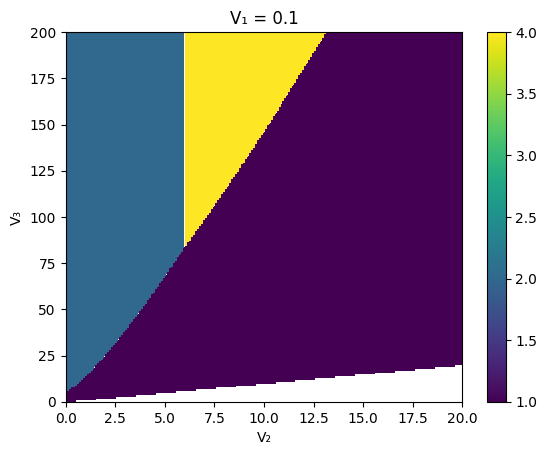

In [17]:
V₁ = 0.1
V₂list, V₂axis = makelist(0, 20, 200)
V₃list, V₃axis = makelist(0, 200, 200)
threshold = 0.01

function compare(V₁, V₂, V₃, threshold)
    if !(V₁≤V₂≤V₃)
        return NaN
    end
    candidates = [per213(V₁, V₂, V₃), per3123(V₁, V₂, V₃), per2313(V₁, V₂, V₃), per32123(V₁, V₂, V₃)]
    val, pos = findmin(candidates)
    for i = 1:4
        if i != pos && !isnan(candidates[i]) && candidates[i] <= val + threshold
            return NaN
        end
    end
    return pos
end     
        
M = [[compare(V₁, V₂, V₃, threshold) for V₂ in V₂list] for V₃ in V₃list]
pcolormesh(V₂axis, V₃axis, M, vmin=1, vmax=4)
title("V₁ = $V₁")
xlabel("V₂")
ylabel("V₃")
colorbar();

In [18]:
function crosssect(V₁)
    V₂list, V₂axis = makelist(0, 150, 400)
    V₃list, V₃axis = makelist(0, 3000, 400)   

    M = [[compare(V₁, V₂, V₃, 1e-4) for V₂ in V₂list] for V₃ in V₃list]
    a = pcolormesh(V₂axis, V₃axis, M, vmin=1, vmax=4)
    title("V₁ = $(@sprintf("%.2f", V₁))")
    xlabel("V₂")
    ylabel("V₃")
    colorbar()
    return [a]
end;

In [19]:
# From https://genkuroki.github.io/documents/Jupyter/20170624%20Examples%20of%20animations%20in%20Julia%20by%20PyPlot%20and%20matplotlib.animation.html

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot

function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

fig = figure(figsize=(8,6))

V₁list = linspace(0.05, 10, 200)

# i=0,1,...,frames-1
function animate(i)
    clf()
    crosssect(V₁list[i+1])
end

function init()
    crosssect(V₁list[1])
end

withfig(fig) do
    myanim = anim.FuncAnimation(fig, animate, frames=length(V₁list), init_func=init, interval=50, blit=true)
    myanim[:save]("triple.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

showanim("triple.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABnOltZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjY0MyA1YzY1NzA0IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAJedliIQAM//+9uy+BTX9n9CXESzYetpdeFsIJ92XnBoTAAADAAADAAADAABTn7W0Q7tBIJoAAAMAAX4ATembJnDbxLHAAYuzI+X8FY8By36RuzMrTNo4J8PNyx3OtAfKfwKcqQMV3sFFOEvlg//P1QlKb/cYNJ+7e3dcQPoOgojnT8Hcw5MX/IR8dICwOdlqnSiJfOLFrOzLVjP0sQKKlyVHBGENdv/NFZ1AJf5UfYWOkCyG/rgYCNXmA0beUMzEHa7f/uYZwWdNTdP3NskYeV3C4cQXHn1/8Hw6Arv71ebheSvaxVmgBt9DF2uIJIg4v07bELFOZs5/aOhueYRgrPf2ngumkMzIHFt9ay4nPHagY9tZv3jGN/icWHbgzy1otNlntfHOw4O2QOKMJv/I7JS6xmnasdwu/AccMoCj/JU9tdK63q5xxd0kY8QErqy9ByPo/IkJC18cWnJFKREcQcqiwrPnPvYYXOvyFhA93ISmtAYLbB5wqj94TD/31ruHfWQiITlnYUcmE9k18d6P7JqQYVluEi9Gu2W62HPGWfQbkJuaLqEi3cB9R0M74MzioYGI7ST89lB8L0m8zr/91tRhYU343al30GFuzJss9yn23tZHwnF401VQp4hdEyDmAIw1gd3zr8WS8cPbOUD3mg6yNWYXL0xDfw7lOsQ6ggGrGoLRdKc+BM/yX7xvWo8VULjC7ZFbm0Yl/l/7Lp0r7q97N4cR+H3cywcCSVIyMR34qMq1aQmpFlEE1qS/6V1YahYJ/pQAoB7iN2XcGLxflys4A0ztb6GdtuCq2xsUY8QMYFWzpZeYRLCru8+oT7PMm0lz4G5mcCgD+XtWw1z2bzP6eRxeaJuouxlAcnQbsrtOQVW3RVpQQnhcqG2zoFF4BHR52f49++Rjk9szuUF+H7zKttdUXfunSc3lziiAEFcytBvCXQQ+y7cAI5Uwz7vjLFnTscl2LxA7iv/uEMk2A+LZF5YWTI5MDK3+NMKNzhzXcHyjbLM2Z1qOyiFN8HABTtisdu8V4jny7015RojWFM1v/nEb87ozTKLKpis4QYbbgmkcYmHeyAFQ2xM4Jo7PtoS6p3kUSUshF97ZG+0AaeV+oypNLX2iBm3k+umt2TbicmR0qWj2oz2scYL9B/vyiqvfWq7leTi/Giw7izRSRvkpiHkTE3szpEq+GWrorEkcLO4kqZXhpBLd8r0/1eQaUfQljw9kF6OkA0pbzcAjS3NkRT1cFQ/dXdir9KYcHOhp1GR/CygYHCjUhmd9Ly9FIJHeomL3Obe7KFJixwRLykTB0CMPL/g0QQ5hXy1qbWcV984SApQHNd2uAE3l/oC5jGMPxGkzIMNBk/htn9sm99obmZ9ivOGBZ9mJmwkcxvxifkNZ0LPkKUvjzVjTsXVTMyZx8iKAndzX2u/DC8C8HGhlW83X8qIf42y8KlcztNmn7nuzzyMyUyaemlfc4tCft4KZnXAR043A8FtYR6jvxap3t+KI/6r2GcOGORMZZohZcYsDu3nEsdgdleg+1B0NxLZ9Eugik62eiTboZ3HH6Yjv42NWqlr6P1k4293SAABQF6B80IWLz8Wpldbil7MHa3DEAOf3qp8tTBbB9P2oDG6aytjfhRdSnjewCf4uKhzOtq6ACRhH/LDGrZ+gzTQ9EasmUvzmUgGMhCK8/edBKQ6DmN5GEfdSyMwbr/HseqWGnCpJcI6refKVJYEp5f9TpQ7y5Ohej/Fs3Xvwu0p1a38Xw8XwokLGNkjZpQZ/BebSADMI8Zx91aBj7/Tv4hM2RU3La91JFibTO54qPkYknN/pAMLL3sN2OP1Kb2ZMLVzNeZ0M2quoOeknOtAfADB6jtOQuYqcAJrqyg4TB1NVASUCtfXEMUZYBMAWZpT9AtGBW+X3VuYfYdEAAxG2zRZ86Jme86G8Ene2Dl0GFerrWI0C8TPQj3341zLItLDYBD1q/8ubZ4M9At+X+dGsKdIiR89f+XPA36U7MAEH9tWJEJ2m3uxzFNJFp3KfLB5mBVoxwflheG3iHY2SJGbtYvTrkmWeiE5G3FrqBqmz8W8Xa7F/HOESjHzQfnnSCChzn/qSx5cCz+8/GsKGt1n8ZOopVxcdwH7M89TNUGk12rZH7fps5XaDvc97rZbqWkAVQB5E2ExzUtQ9PbOUq3RfOqXRAe6cz+ZFZ/B8PFQO8fbCJsFbE1lqpdnkWdQ7tSnDTr2VY9JcDPxLNoo1+rCn0o5N2yOJA0HoOJBdXa5pAk8yljN6OGua8KU+kUwCCnd/eqVukUTD0qgw+NiWW+TlMsQLhu5qQ0dyFYFwexSRqe4sSmwcicHcfaP/QGv8bg+BoS10F/5hqUkhO/qdK+IQE7S/7Xr7hkOrX4m0vD00KSbwp4xBfRPXR3Lb38n3I9CkjYmQOX0pXP5QOKPBKA2g9/Ytv0WeLDTUnq60fWOLZpQ7aBkQmgtJnsQYSyhljUw5yXPnHe2E1XOCkv8chycsNCZ+gfNu3StET+Nohpr2u6K8sgnzMLcmnhyKoHdUmavS4EyeK/czuk/qEl/7SwStVZrMU3GTx7lsRw8KfN1BimKtRqRxc57XK7NQVn1k9IwgOpvqj8FraWVaKtCAtI3XFt3OO6awyaU8aRtEZXVLdBKqq+5gE8KlBrTdYDwvj6dqQZBCjKzno+8tac+o3x1hM78WgZhnYhj6QLRWuRp1GvNDIpe8eXceQcn3sWKQEeEKVgN0fgUrsbtXvcZwxFc/lcmo878/XYIF1aYUfkuw9bNswteo57q+9zfy898zofu4CK6Jmebna8TNeAr5jy+9tUWviNhAJVHOWEjolqp3/imHAjyoimmLYeUN3HoKct4tSTfnFiguE+dmq3DdkOdv95ySurDvigOsPm/9xaBY0PNc8UXolII/94ayiD8tc2cZQ3t4efEU1x+CAD3gf6beCR+Hfl8FqZcrKg3pMRG1+8eZbUr